In [1]:
#generate 

from ipsl_dcpp.model.ipsl_dataset import IPSL_DCPP
import torch
import lightning as pl
from ipsl_dcpp.model.pangu import PanguWeather
from hydra import compose, initialize
from omegaconf import OmegaConf
import hydra
import numpy as np
import os
os.environ['SLURM_NTASKS_PER_NODE'] = '1'
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
pl.seed_everything(cfg.experiment.seed)

train = hydra.utils.instantiate(
    cfg.experiment.train_dataset,
    generate_statistics=False,
    surface_variables=cfg.experiment.surface_variables,
    depth_variables=cfg.experiment.depth_variables,
    plev_variables=cfg.experiment.plev_variables,
    work_path=cfg.environment.work_path,
    scratch_path=cfg.environment.scratch_path,
)
train_dataloader = torch.utils.data.DataLoader(
    train,
    batch_size=1,
    shuffle=False,
    num_workers=1
)



Seed set to 0
9it [00:01,  5.85it/s]


In [2]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim=(1,143,144), hidden_num=144):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_num, bias=True)
        self.fc2 = nn.Linear(hidden_num, hidden_num, bias=True)
        self.fc3 = nn.Linear(hidden_num, input_dim, bias=True)
        self.act = lambda x: torch.tanh(x)

    def forward(self, x_input, t):

        inputs = torch.cat([x_input, t], dim=0)
      #  print(inputs.shape)
        x = self.fc1(inputs)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)
        x = x.mean(dim=0)

        return x

In [3]:
#generate X_0 (noise) and X_1 (image) pairs

model = hydra.utils.instantiate(
    cfg.experiment.module,
    backbone=hydra.utils.instantiate(
        cfg.experiment.backbone,
    ),
    dataset=train_dataloader.dataset
)


checkpoint_path = torch.load(f'../epoch=30.ckpt',map_location=torch.device('cpu'))
model.load_state_dict(checkpoint_path['state_dict'])
# trainer.test(model, val_dataloader)
# inv_map = {v: k for k, v in val.id2pt.items()}


/Users/gclyne/miniforge3/envs/env_dcpp/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025535429/work/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

In [4]:
model.backbone

PanguWeather(
  (loss): MSELoss()
  (patchembed2d): PatchEmbed2D(
    (pad): ZeroPad2d((0, 0, 0, 1))
    (proj): Conv2d(19, 192, kernel_size=(2, 2), stride=(2, 2))
  )
  (layer1): CondBasicLayer(
    (blocks): ModuleList(
      (0): EarthSpecificBlock(
        (norm1): LayerNorm((192,), eps=1e-10, elementwise_affine=True)
        (pad): ZeroPad3d((0, 0, 0, 0, 0, 1))
        (attn): EarthAttention3D(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
          (softmax): Softmax(dim=-1)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=768, out_features=192, bias=True

In [5]:
batch = next(iter(train_dataloader))
pairs = []
for i in range(5):
    image = model.sample(batch, denormalize=False,num_inference_steps=model.num_inference_steps,scheduler=model.scheduler)
    pairs.append((image[0],image[-1]))
import pickle 
output = open('rectified_flow_pairs.pkl', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(pairs, output) 

tensor(900)
tensor(800)
tensor(700)
tensor(600)
tensor(500)
tensor(400)
tensor(300)
tensor(200)
tensor(100)
tensor(0)
tensor(900)
tensor(800)
tensor(700)
tensor(600)
tensor(500)
tensor(400)
tensor(300)
tensor(200)
tensor(100)
tensor(0)
tensor(900)
tensor(800)
tensor(700)
tensor(600)
tensor(500)
tensor(400)
tensor(300)
tensor(200)
tensor(100)
tensor(0)
tensor(900)
tensor(800)
tensor(700)
tensor(600)
tensor(500)
tensor(400)
tensor(300)
tensor(200)
tensor(100)
tensor(0)
tensor(900)
tensor(800)
tensor(700)
tensor(600)
tensor(500)
tensor(400)
tensor(300)
tensor(200)
tensor(100)
tensor(0)
tensor(900)
tensor(800)
tensor(700)
tensor(600)
tensor(500)
tensor(400)
tensor(300)
tensor(200)
tensor(100)
tensor(0)
tensor(900)
tensor(800)
tensor(700)
tensor(600)
tensor(500)
tensor(400)
tensor(300)
tensor(200)
tensor(100)
tensor(0)
tensor(900)
tensor(800)
tensor(700)
tensor(600)
tensor(500)
tensor(400)
tensor(300)
tensor(200)
tensor(100)
tensor(0)
tensor(900)
tensor(800)
tensor(700)
tensor(600)
tensor(5

In [9]:
pairs_ = [(x[0]['state_surface'],x[1]) for x in pairs]
images = torch.stack([x[0] for x in pairs_])
noise = torch.stack([x[1] for x in pairs_])
pairs_ = torch.stack([images,noise],dim=1)

In [10]:
image_var = images[0,0,0,:,:].reshape(1,-1).numpy()

In [12]:
image_var.shape

(1, 20592)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-0.29826841, -0.2916218 , -0.28497517, -0.27832854, -0.27168193,
        -0.26503533, -0.2583887 , -0.25174206, -0.24509546, -0.23844884,
        -0.23180223, -0.22515561, -0.21850899, -0.21186237, -0.20521575,
        -0.19856913, -0.19192252, -0.1852759 , -0.17862928, -0.17198266,
        -0.16533604, -0.15868942, -0.15204281, -0.14539619, -0.13874957,
        -0.13210295, -0.12545633, -0.11880971, -0.1121631 , -0.10551648,
        -0.09886986, -0.09222324, -0.08557662, -0.07893001, -0.07228339,
        -0.06563677, -0.05899015, -0.05234353, -0.04569691, -0.0390503 ,
        -0.03240368, -0.02575706, -0.01911044, -0.01246382, -0.0058172 ,
         0.00082941,  0.00747603,  0.01412265,  0.02076927,  0.02741589,
         0.0340625 , 

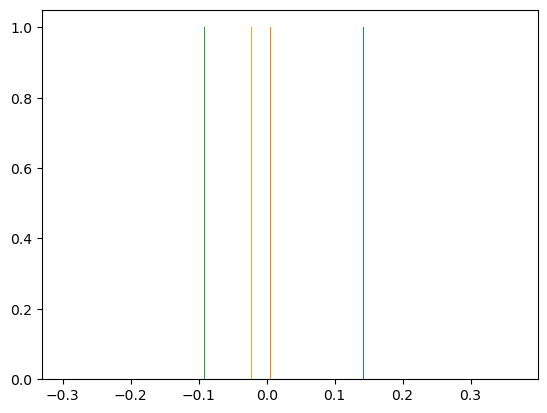

In [14]:
import matplotlib.pyplot as plt
plt.hist(image_var[:,:5000],bins=100)

In [8]:
class RectifiedFlow():
  def __init__(self, model=None, num_steps=1000):
    self.model = model
    self.N = num_steps

  def get_train_tuple(self, z0=None, z1=None):
 #   print(z0.shape)
 #   print(z1.shape)
    t = torch.rand((z1.shape[0], 143,144))
#    print(t.shape)
    z_t =  t * z1 + (1.-t) * z0
    target = z1 - z0

    return z_t, t, target

  @torch.no_grad()
  def sample_ode(self, z0=None, N=None):
    ### NOTE: Use Euler method to sample from the learned flow
    if N is None:
      N = self.N
    dt = 1./N
    traj = [] # to store the trajectory
    z = z0.detach().clone()
    batchsize = z.shape[0]

    traj.append(z.detach().clone())
    for i in range(N):
      t = torch.ones((batchsize,143,144)) * i / N
    #  print(z.shape)
    #  print(t.shape) 
      pred = self.model(z, t)
    #  print('pred',pred.shape)
    #  print(z.shape)
    #  print(dt)
      z = z.detach().clone() + pred * dt
      
      traj.append(z.detach().clone())
    #  print(len(traj),'traj length')
    return traj

In [9]:
def train_rectified_flow(rectified_flow, optimizer, pairs, batchsize, inner_iters):
  loss_curve = []
  for i in range(inner_iters+1):
    optimizer.zero_grad()
    indices = torch.randperm(len(pairs))[:batchsize]
  #  print(indices)
    batch = pairs[indices][0]
  #  print(batch.shape)
    z0 = batch[0].detach().clone()
    z1 = batch[1].detach().clone()
    z_t, t, target = rectified_flow.get_train_tuple(z0=z0, z1=z1)

    pred = rectified_flow.model(z_t, t)
   # print(pred.shape)
    loss = (target - pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
    loss = loss.mean()
    loss.backward()

    optimizer.step()
    loss_curve.append(np.log(loss.item())) ## to store the loss curve

  return rectified_flow, loss_curve


In [10]:
iterations = 5000
batchsize = 1
import matplotlib.pyplot as plt
rectified_flow_1 = RectifiedFlow(model=model.backbone, num_steps=4000)
optimizer = torch.optim.Adam(rectified_flow_1.model.parameters(), lr=5e-3)

rectified_flow_1, loss_curve = train_rectified_flow(rectified_flow_1, optimizer, pairs, batchsize, iterations)
plt.plot(np.linspace(0, iterations, iterations+1), loss_curve[:(iterations+1)])
plt.title('Training Loss Curve')

KeyError: 0

In [ ]:
D = 10.
M = D+5

@torch.no_grad()
def draw_plot(rectified_flow, z0, z1, N=None):
  traj = rectified_flow.sample_ode(z0=z0, N=N)
  print(len(traj))
  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)
  
  plt.scatter(z1[:, 0].cpu().numpy(), z1[:, 1].cpu().numpy(), label=r'$\pi_1$', alpha=0.15)
  plt.scatter(z0[:, 0].cpu().numpy(), z0[:, 1].cpu().numpy(), label=r'$\pi_0$', alpha=0.15)
  plt.scatter(traj[-1][:, 0].cpu().numpy(), traj[-1][:, 1].cpu().numpy(), label='Generated', alpha=0.15)
  plt.legend()
  plt.title('Distribution')
  plt.tight_layout()

  traj_particles = torch.stack(traj)
  print('particles',traj_particles.shape)
  traj_particles = traj_particles.reshape(101,143*144)
  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)
  print(traj_particles.shape)
  plt.axis('equal')
  for i in range(143*144):
    plt.plot(traj_particles[:,i], traj_particles[:,i])
  plt.title('Transport Trajectory')
  plt.tight_layout()

In [ ]:
pairs[:,0,0].shape

torch.Size([10, 143, 144])

101
particles torch.Size([101, 1, 143, 144])
torch.Size([101, 20592])


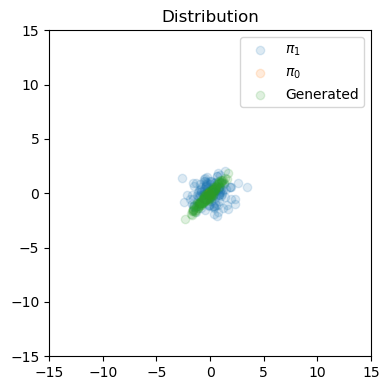

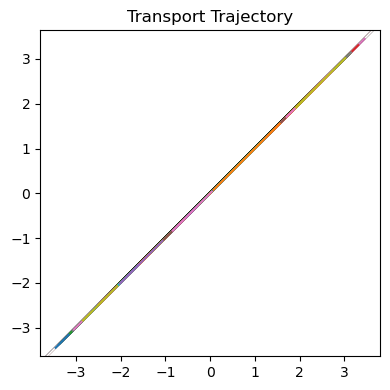

In [ ]:
images = pairs[0,0]
noise = pairs[0,1]
# i = images.swapaxes(2,-1).reshape(10*143*144,9)
# n = noise.swapaxes(2,-1).reshape(10*143*144,9)
draw_plot(rectified_flow_1, z0=images, z1=noise, N=100)

KeyboardInterrupt: 

: 

: 